<a href="https://colab.research.google.com/github/EikEUFS/AprendizadoDeMaquina/blob/main/AM_Tarefa05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U mxnet-cu110==1.8.0
!pip uninstall pycaret
!pip install -U pycaret-nightly

Requirement already up-to-date: mxnet-cu110==1.8.0 in /usr/local/lib/python3.7/dist-packages (1.8.0)
     |████████████████████████████████| 266kB 6.6MB/s 
     |████████████████████████████████| 174kB 13.0MB/s 
     |████████████████████████████████| 2.0MB 14.6MB/s 
     |████████████████████████████████| 6.8MB 49.8MB/s 
     |████████████████████████████████| 14.2MB 222kB/s 
     |████████████████████████████████| 276kB 49.6MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
     |████████████████████████████████| 1.4MB 46.4MB/s 
     |████████████████████████████████| 256kB 55.0MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 112kB 57.5MB/s 
     |████████████████████████████████| 1.7MB 36.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 174kB 47.6MB/s 
     |

In [2]:
from mxnet import np, npx, init, gluon
from mxnet.gluon import utils as gutils
from mxnet.gluon import nn, rnn
import pandas as pd

from gensim.models import KeyedVectors

npx.set_np()

In [3]:
!wget https://raw.githubusercontent.com/EikEUFS/AprendizadoDeMaquina/main/_aux.py
!wget https://www.dropbox.com/s/yrgcc9pb1uz7zp9/imdb.csv
!wget https://www.dropbox.com/s/wehf8dx2ecwbb7f/skip_s100.txt

import _aux

--2021-06-02 00:09:33--  https://raw.githubusercontent.com/EikEUFS/AprendizadoDeMaquina/main/_aux.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121721 (119K) [text/plain]
Saving to: ‘_aux.py’

_aux.py             100%[===================>] 118.87K  --.-KB/s    in 0.02s   

2021-06-02 00:09:33 (7.46 MB/s) - ‘_aux.py’ saved [121721/121721]

--2021-06-02 00:09:33--  https://www.dropbox.com/s/yrgcc9pb1uz7zp9/imdb.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/yrgcc9pb1uz7zp9/imdb.csv [following]
--2021-06-02 00:09:33--  https://www.dropbox.com/s/raw/yrgcc9

In [4]:
cols = ["id", "sentence_eng", "sentence", "label"]
df = pd.read_csv("/content/imdb.csv", sep=',', names=cols, header=0, encoding='utf-8')
df.drop(["id", "sentence_eng"], axis=1, inplace=True)

df['label'] = df['label'].map({'pos': 1, 'neg':0})

train_df = df.sample(frac=0.8, random_state=200)
test_df = df.drop(train_df.index)

In [5]:
test_df

,sentence,label
2,"Primeiro de tudo eu odeio esses raps imbecis, ...",0
3,Nem mesmo os Beatles puderam escrever músicas ...,0
4,Filmes de fotos de latão não é uma palavra apr...,0
5,Uma coisa engraçada aconteceu comigo enquanto ...,0
17,A terra foi destruída em um holocausto nuclear...,0
...,...,...
49441,Como talvez um dos poucos canadenses que não l...,1
49444,Eu tive a chance de ver uma exibição desse fil...,1
49448,... este é um clássico com tantos grandes diál...,1
49453,Life Stinks 1991 foi um passo abaixo de outras...,1


In [6]:
def load_data(batch_size, num_steps=500):
    train_tokens = _aux.tokenize(train_df['sentence'], token='word')
    test_tokens = _aux.tokenize(test_df['sentence'], token='word')

    vocab = _aux.Vocab(train_tokens, min_freq=5)

    train_features = np.array([_aux.truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = np.array([_aux.truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    
    train_iter = _aux.load_array((train_features, train_df['label']), batch_size)
    test_iter = _aux.load_array((test_features, test_df['label']), batch_size, is_train=False)

    return train_iter, test_iter, vocab

class BiRNN(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers, bidirectional=True, input_size=embed_size)
        self.decoder = nn.Dense(2)

    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        outputs = self.encoder(embeddings)
        encoding = np.concatenate((outputs[0], outputs[-1]), axis=1)
        outs = self.decoder(encoding)
        return outs

batch_size = 64
train_iter, test_iter, vocab = load_data(batch_size)

embed_size, num_hiddens, num_layers, devices = 100, 100, 2, _aux.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=devices)

In [7]:
%time
model = KeyedVectors.load_word2vec_format('/content/skip_s100.txt')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [8]:
w2v = model.vectors[:len(vocab), :]
net.embedding.weight.set_data(w2v)
net.embedding.collect_params().setattr('grad_req', 'null')

lr, num_epochs = 0.01, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


KeyError: ignored

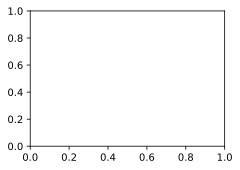

In [9]:
%time
_aux.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
def predict_sentiment(net, vocab, sentence):
    sentence = np.array(vocab[sentence.split()], ctx=aux.try_gpu())
    label = np.argmax(net(sentence.reshape(1, -1)), axis=1)
    return 'positivo' if label == 1 else 'negativo'

print(predict_sentiment(net, vocab, 'Este filme é legal!'))
print(predict_sentiment(net, vocab, 'Este filme é ruim!'))